## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems (Fall 2020)

#### Dr. Haiquan Chen, California State University, Sacramento

In [ ]:
# Insert your name, your id, course title, assignment id, and due date here as comment 

#Cristian Romo
#218999054
#CSC 180 - Intelligent Systems
#Project 3
#10/30/2020



## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [3]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [4]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [5]:
#  Load cifar-10 data and split it to training and test


from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [6]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [7]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

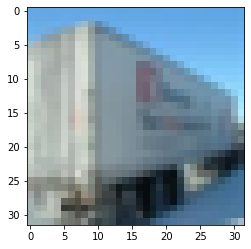

In [61]:
# print it out as image

import matplotlib.pyplot as plt


plt.imshow(x_train[15])

In [62]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [63]:
y_train.shape

# expected output: (50000,)

(50000,)

In [64]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [65]:
y_test.shape

# expected output: (10000,)

(10000,)

In [66]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [67]:
# Convert data from int to float and normalize it


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
img_rows, img_cols = 32,32

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

# **Model with Relu activation**


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [73]:
# Print model summary

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)         

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping




In [77]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=1, verbose=0, mode='auto')

model.fit(x_train, y_train,
          validation_data=(x_test,y_test),
          callbacks=[monitor], 
          verbose=2,
          epochs=10)

print("Done")

Epoch 1/10
1563/1563 - 6s - loss: 0.6907 - accuracy: 0.7581 - val_loss: 0.7661 - val_accuracy: 0.7391
Epoch 2/10
1563/1563 - 6s - loss: 0.6593 - accuracy: 0.7684 - val_loss: 0.7945 - val_accuracy: 0.7311
Done


### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [78]:
from sklearn import metrics
y_true = np.argmax(y_test,axis=1)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))


Precision score: 0.7358110731995278
Recall score: 0.7311
F1 score: 0.7294199785686911
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      1000
           1       0.88      0.83      0.85      1000
           2       0.65      0.64      0.65      1000
           3       0.59      0.47      0.52      1000
           4       0.63      0.76      0.68      1000
           5       0.65      0.62      0.64      1000
           6       0.88      0.70      0.78      1000
           7       0.83      0.77      0.80      1000
           8       0.76      0.89      0.82      1000
           9       0.82      0.80      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.



## Part II:   CNN model with Transfer Learning

Predicted: Automobile
Actual: Automobile


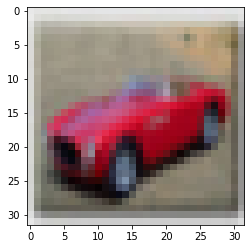

In [79]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


print("Predicted: {}".format(img_labels[pred[1234]]))
print("Actual: {}".format(img_labels[y_true[1234]]))
mpl.imshow(x_test[1234])


Predicted: Airplane
Actual: Airplane


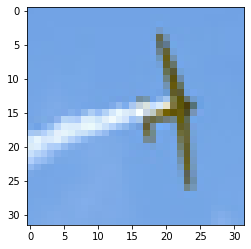

In [80]:
print("Predicted: {}".format(img_labels[pred[2468]]))
print("Actual: {}".format(img_labels[y_true[2468]]))
mpl.imshow(x_test[2468])


Predicted: Deer
Actual: Frog


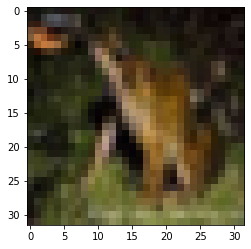

In [81]:
print("Predicted: {}".format(img_labels[pred[2222]]))
print("Actual: {}".format(img_labels[y_true[2222]]))
mpl.imshow(x_test[2222])

Predicted: Dog
Actual: Cat


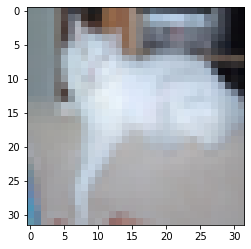

In [82]:
print("Predicted: {}".format(img_labels[pred[2612]]))
print("Actual: {}".format(img_labels[y_true[2612]]))
mpl.imshow(x_test[2612])

#**First model, now with Sigmoid Activation**




In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


model = Sequential()
model.add(Conv2D(32, (4,4), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))


In [57]:
# Print model summary

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        1568      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)         

In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=1, verbose=0, mode='auto')

model.fit(x_train, y_train,
          validation_data=(x_test,y_test),
          callbacks=[monitor], 
          verbose=2,
          epochs=30)

print("Done")

Epoch 1/30
1563/1563 - 5s - loss: 1.8327 - val_loss: 1.5340
Epoch 2/30
1563/1563 - 5s - loss: 1.4940 - val_loss: 1.3165
Epoch 3/30
1563/1563 - 5s - loss: 1.3437 - val_loss: 1.2069
Epoch 4/30
1563/1563 - 5s - loss: 1.2386 - val_loss: 1.1363
Epoch 5/30
1563/1563 - 5s - loss: 1.1616 - val_loss: 1.0492
Epoch 6/30
1563/1563 - 5s - loss: 1.0962 - val_loss: 1.0227
Epoch 7/30
1563/1563 - 5s - loss: 1.0513 - val_loss: 0.9908
Epoch 8/30
1563/1563 - 5s - loss: 1.0162 - val_loss: 0.9481
Epoch 9/30
1563/1563 - 5s - loss: 0.9668 - val_loss: 0.9341
Epoch 10/30
1563/1563 - 5s - loss: 0.9386 - val_loss: 0.9294
Epoch 11/30
1563/1563 - 5s - loss: 0.8999 - val_loss: 0.9007
Epoch 12/30
1563/1563 - 5s - loss: 0.8641 - val_loss: 0.8949
Epoch 13/30
1563/1563 - 5s - loss: 0.8392 - val_loss: 0.9483
Done


In [59]:
from sklearn import metrics
y_true = np.argmax(y_test,axis=1)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))


Precision score: 0.6806410673626088
Recall score: 0.6813
F1 score: 0.6754370810852804
              precision    recall  f1-score   support

           0       0.62      0.79      0.69      1000
           1       0.79      0.86      0.82      1000
           2       0.55      0.58      0.56      1000
           3       0.56      0.42      0.48      1000
           4       0.64      0.58      0.61      1000
           5       0.67      0.48      0.56      1000
           6       0.71      0.79      0.75      1000
           7       0.78      0.73      0.75      1000
           8       0.68      0.87      0.76      1000
           9       0.80      0.72      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



Predicted: Automobile
Actual: Automobile


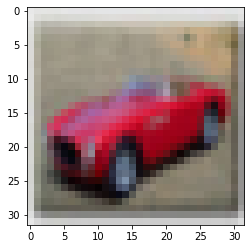

In [60]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


print("Predicted: {}".format(img_labels[pred[1234]]))
print("Actual: {}".format(img_labels[y_true[1234]]))
mpl.imshow(x_test[1234])


Predicted: Airplane
Actual: Airplane


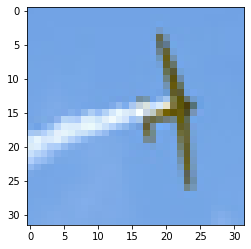

In [61]:
print("Predicted: {}".format(img_labels[pred[2468]]))
print("Actual: {}".format(img_labels[y_true[2468]]))
mpl.imshow(x_test[2468])


Predicted: Frog
Actual: Frog


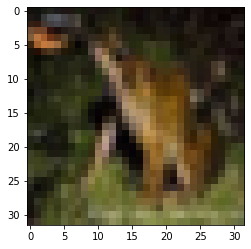

In [62]:
print("Predicted: {}".format(img_labels[pred[2222]]))
print("Actual: {}".format(img_labels[y_true[2222]]))
mpl.imshow(x_test[2222])

Predicted: Horse
Actual: Cat


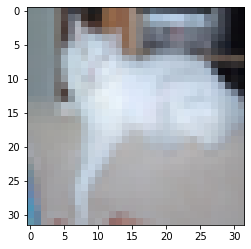

In [63]:
print("Predicted: {}".format(img_labels[pred[2612]]))
print("Actual: {}".format(img_labels[y_true[2612]]))
mpl.imshow(x_test[2612])

# Loading data again for TL

In [8]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Things to note: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### (2) Apply upsampling to x_train and x_test seperately. 

In [9]:
import skimage.transform

new_x_train = []

for image_32 in x_train:
  image_64 = skimage.transform.resize(image_32, (64, 64))
  new_x_train.append(image_64)

new_x_train = np.asarray(new_x_train)

# this process may take about a few minutes ....

In [10]:
new_x_test = []

for image_32 in x_test:
  image_64 = skimage.transform.resize(image_32, (64, 64))
  new_x_test.append(image_64)

new_x_test = np.asarray(new_x_test)

# this process may take about a few minutes ....

### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [11]:
# Convert from 2D to 1D 
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [12]:
# double check shape

print(y_train.shape)
print(y_test.shape)


# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

model = Sequential()
  
#write your code here
for layer in vgg_model.layers:
  model.add(layer)

# print out the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Write your code in the cell below to freeze the weights in each layer in the new model

In [19]:

for layer in model.layers:
  layer.trainable = False


###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [20]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer
model.add(Dense(250, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# print out the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


batch_size = 128
checkpointer = ModelCheckpoint(filepath='vgg16_immitation.hdf5', verbose=0, save_best_only=True)


model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=0, verbose=0, mode='auto')
model.fit(new_x_train, y_train,     
          batch_size=batch_size,
          epochs=30,
          verbose=2,
          validation_data=(new_x_test, y_test),
          callbacks=[monitor, checkpointer])

# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/30
391/391 - 21s - loss: 1.1260 - accuracy: 0.6116 - val_loss: 0.9782 - val_accuracy: 0.6643
Epoch 2/30
391/391 - 20s - loss: 0.8987 - accuracy: 0.6875 - val_loss: 0.9273 - val_accuracy: 0.6787
Epoch 3/30
391/391 - 21s - loss: 0.8231 - accuracy: 0.7117 - val_loss: 0.8986 - val_accuracy: 0.6873
Epoch 4/30
391/391 - 20s - loss: 0.7704 - accuracy: 0.7312 - val_loss: 0.8806 - val_accuracy: 0.6928
Epoch 5/30
391/391 - 20s - loss: 0.7155 - accuracy: 0.7487 - val_loss: 0.8895 - val_accuracy: 0.6916


### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [23]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)

pred = model.predict(new_x_test)
pred = np.argmax(pred,axis=1)

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))




Precision score: 0.7038845549906068
Recall score: 0.6916
F1 score: 0.690937422747954
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1000
           1       0.86      0.71      0.78      1000
           2       0.64      0.63      0.63      1000
           3       0.54      0.46      0.50      1000
           4       0.76      0.51      0.61      1000
           5       0.51      0.72      0.60      1000
           6       0.65      0.79      0.71      1000
           7       0.79      0.72      0.75      1000
           8       0.79      0.82      0.81      1000
           9       0.70      0.84      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

Predicted: Frog
Actual: Automobile


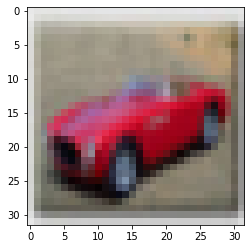

In [25]:
import matplotlib.pyplot as mpl
img_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print("Predicted: {}".format(img_labels[pred[1234]]))
print("Actual: {}".format(img_labels[y_true[1234]]))
mpl.imshow(x_test[1234])


Predicted: Airplane
Actual: Airplane


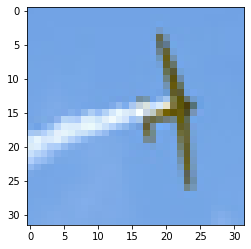

In [26]:
print("Predicted: {}".format(img_labels[pred[2468]]))
print("Actual: {}".format(img_labels[y_true[2468]]))
mpl.imshow(x_test[2468])

Predicted: Frog
Actual: Frog


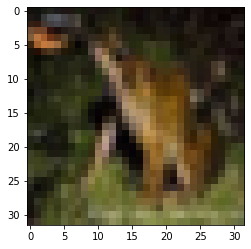

In [27]:
print("Predicted: {}".format(img_labels[pred[2222]]))
print("Actual: {}".format(img_labels[y_true[2222]]))
mpl.imshow(x_test[2222])

Predicted: Dog
Actual: Cat


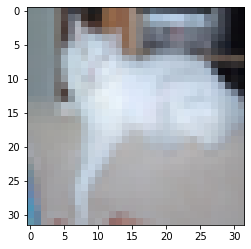

In [28]:
print("Predicted: {}".format(img_labels[pred[2612]]))
print("Actual: {}".format(img_labels[y_true[2612]]))
mpl.imshow(x_test[2612])